In [23]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import graphviz
from IPython.display import Image


In [2]:
data = pd.read_csv('../../Finalized Data/final_with_race.csv')

In [3]:
data.drop(['File','days_jail_doc','Unnamed: 0', 'Unanimous'],axis=1,inplace=True)

In [4]:
y = data.pop('Y')

In [5]:
X = data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

In [7]:
tree = tree.DecisionTreeClassifier()

In [8]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [10]:
forecast = tree.predict_proba(X_test)[:,1]

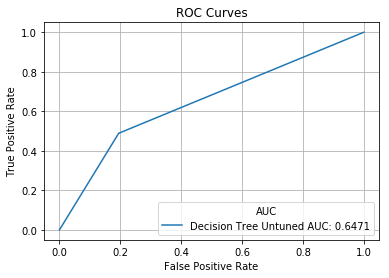

In [13]:
plot_roc(y_test, forecast,'Decision Tree Untuned')
plt.show()

In [12]:
def plot_roc(actual,forecast,name):
    
    #ROC
    fpr, tpr, thresholds = metrics.roc_curve(actual, forecast)

    #AUC
    aucc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = name + ' AUC: '+str(round(aucc, 4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.grid(True)
    plt.legend(loc = 'lower right', title='AUC')

### Tuning

In [14]:
#Grid search
param_grid = [
    {'criterion' : ['gini', 'entropy'],
     'max_depth': [5,10,50,None],
      'min_samples_split': [20, 50, 100],}  
]

In [18]:
grid_search = GridSearchCV(tree, param_grid=param_grid, scoring= 'roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 50, None], 'min_samples_split': [20, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [19]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 100}

In [25]:
t = tree.DecisionTreeClassifier()

In [27]:
best_tree = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, min_samples_split= 100)

In [28]:
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [64]:
forecast = best_tree.predict_proba(X_test)[:,1]

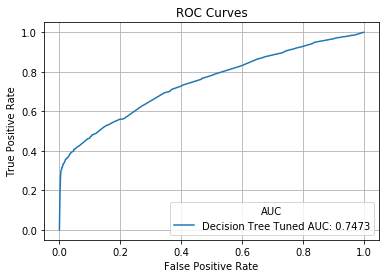

In [65]:
plot_roc(y_test, forecast,'Decision Tree Tuned')
plt.show()

In [66]:
tree.export_graphviz(best_tree, out_file='tree_classifier.dot', feature_names=X_train.columns.values,
                    class_names=['0','1'])

In [67]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

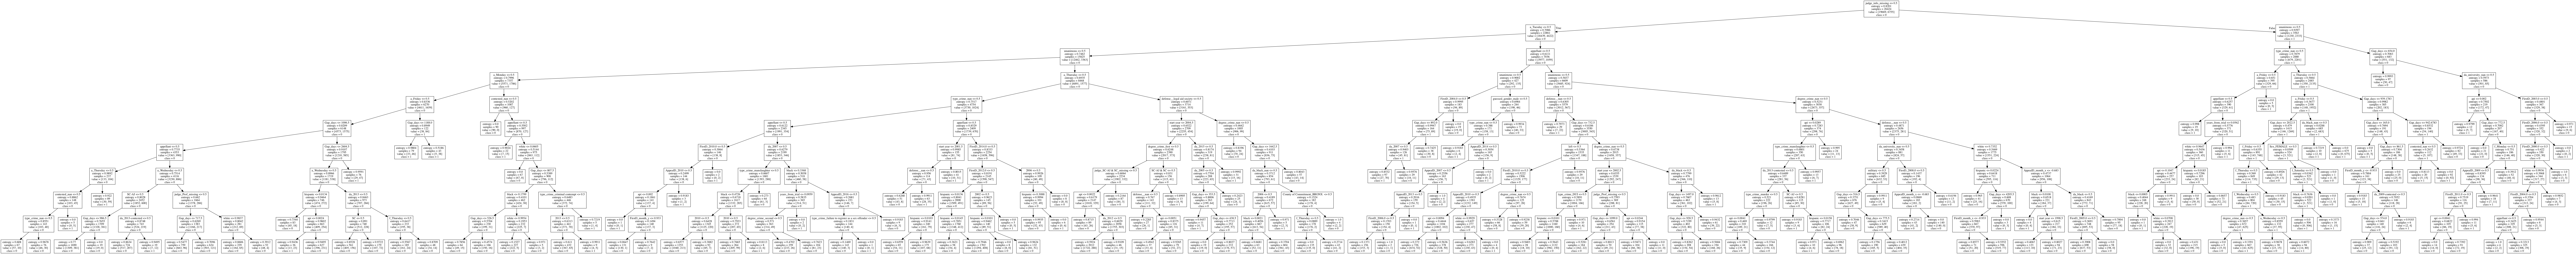

In [68]:
Image(filename='tree_classifier.png')

In [71]:
show_most_informative_features(best_tree, X_train.columns.values)

	0.3546	judge_info_missing	
	0.1086	unanimous      	
	0.1078	type_crime_nan 	
	0.0794	Gap_days       	
	0.0602	a_Thursday     	
	0.0281	appellant      	
	0.0260	a_Friday       	
	0.0149	a_Monday       	
	0.0147	a_Tuesday      	
	0.0126	defense__nan   	
	0.0124	hispanic       	
	0.0118	api            	
	0.0113	degree_crime_nan	
	0.0102	f_Thursday     	
	0.0101	white          	
	0.0088	a_Wednesday    	
	0.0084	black          	
	0.0075	f_Friday       	
	0.0069	start year     	
	0.0064	contested_nan  	


In [57]:
#Test smaller tree for visualizing
small_tree = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, min_samples_split= 500)

In [58]:
small_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=500, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [59]:
forecast = small_tree.predict_proba(X_test)[:,1]

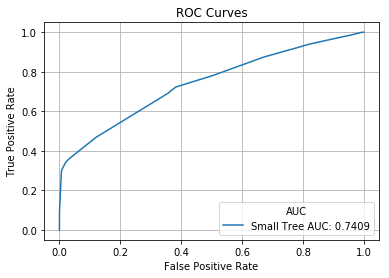

In [60]:
plot_roc(y_test, forecast,'Small Tree')
plt.show()

In [61]:
tree.export_graphviz(small_tree, out_file='small_tree.dot', feature_names=X_train.columns.values,
                    class_names=['0','1'])

In [62]:
!dot -Tpng tree_classifier.dot -o small_tree.png

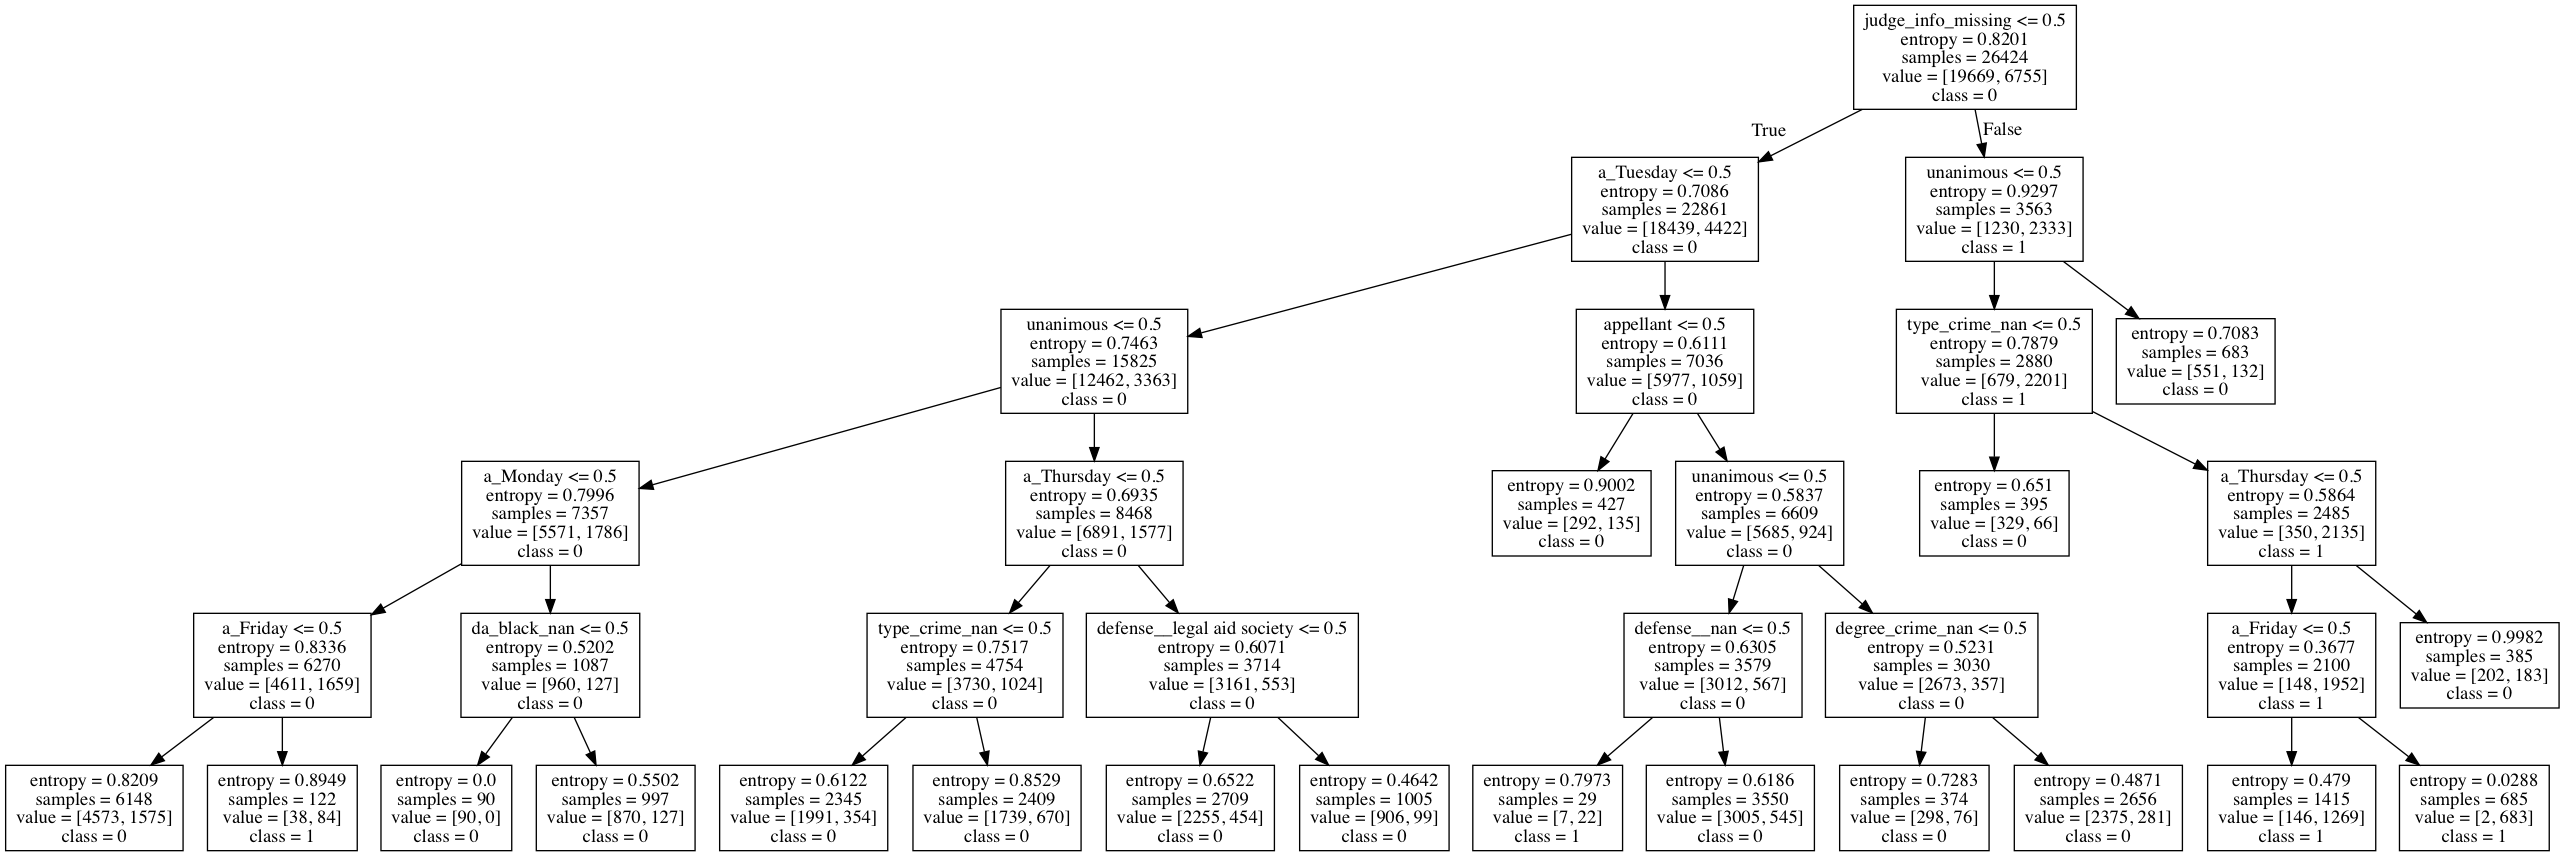

In [63]:
Image(filename='small_tree.png')

In [69]:
def show_most_informative_features(model, names, n=20):
    feature_names = names
    coefs = model.feature_importances_
    coefs_with_fns = sorted(zip(coefs, feature_names),reverse=True)
    top = coefs_with_fns[:n]
    for (coef_1, fn_1) in top:
        
        print("\t%.4f\t%-15s\t" % (coef_1, fn_1))